In [1]:
from sim_with_warp import generate_clustered_survival_data_warp,generate_clustered_survival_data
from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

In [220]:
# Generate and plot
np.random.seed(42)
data_no_warp = generate_clustered_survival_data_warp(N=10000, D=20, T=50, K=7, P=5, warping=False)
data_warp = generate_clustered_survival_data_warp(N=10000, D=20, T=50, K=7, P=5, warping=True)

/Users/sarahurbut/aladynoulli2/pyScripts/sim_with_warp.py:202: RuntimeWarning: divide by zero encountered in matmul
  eta = G @ beta_warp  # [N, K]
/Users/sarahurbut/aladynoulli2/pyScripts/sim_with_warp.py:202: RuntimeWarning: overflow encountered in matmul
  eta = G @ beta_warp  # [N, K]
/Users/sarahurbut/aladynoulli2/pyScripts/sim_with_warp.py:202: RuntimeWarning: invalid value encountered in matmul
  eta = G @ beta_warp  # [N, K]


In [66]:
pi = data_warp['pi']  # [N, D, T]

import numpy as np
import matplotlib.pyplot as plt

d = 0  # Choose a disease index to analyze

# Find onset time for each individual (first time pi > threshold)
threshold = 0.001
onset_times = (pi[:, d, :] > threshold).argmax(axis=1)
valid = (pi[:, d, :].max(axis=1) > threshold)
onset_times = onset_times[valid]

# Find early onset individuals (e.g., lower quartile)
early_cutoff = np.percentile(onset_times, 25)
early_inds = np.where(onset_times <= early_cutoff)[0]

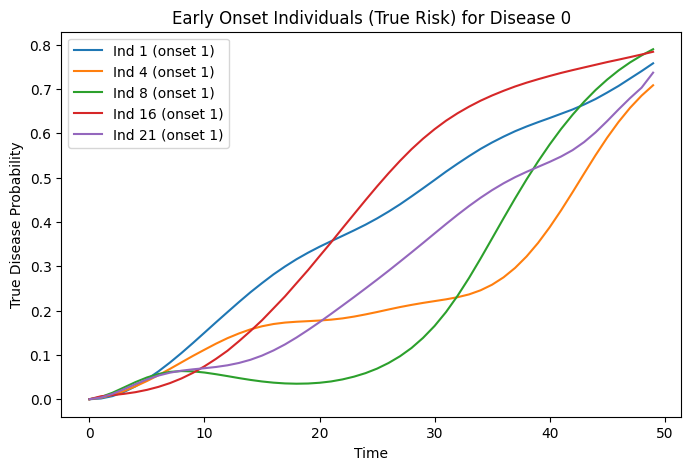

In [67]:
plt.figure(figsize=(8, 5))
for idx in early_inds[:5]:
    plt.plot(pi[valid][idx, d, :], label=f'Ind {idx} (onset {onset_times[idx]})')
plt.xlabel('Time')
plt.ylabel('True Disease Probability')
plt.title('Early Onset Individuals (True Risk) for Disease {}'.format(d))
plt.legend()
plt.savefig('early_onset_true.pdf')
plt.show()

In [225]:
# First generate synthetic data
from sim_with_warp import compute_smoothed_prevalence
np.random.seed(42)
data=data_warp
# Convert data to tensors for the model
Y_tensor = torch.tensor(data['Y'], dtype=torch.float32)
G_tensor = torch.tensor(data['G'], dtype=torch.float32)
E_tensor = torch.tensor(data['event_times'], dtype=torch.float32)
true_psi = torch.tensor(data['psi'], dtype=torch.float32)


# Calculate prevalence_t from synthetic data
prevalence_t = compute_smoothed_prevalence(Y_tensor)  # Average over individuals



In [131]:

from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
np.random.seed(42)
torch.manual_seed(42)
model_warp = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True,
    disable_warping=True
)


pi1, _, _ = model_warp.forward()

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 5 diseases
Cluster 1: 3 diseases
Cluster 2: 2 diseases
Cluster 3: 4 diseases
Cluster 4: 2 diseases
Cluster 5: 3 diseases
Cluster 6: 1 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 5
Base value (first 5): tensor([ -9.8460, -13.8155, -11.8308, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 2.4577, -1.5118,  0.4730, -1.5118, -1.5118])
Base value centered mean: -2.3704528757662047e-06
Gamma init for k=0 (first 5): tensor([ 0.5726,  0.4501, -0.3418,  0.0980, -0.0314])

Calculating gamma for k=1:
Number of diseases in cluster: 3
Base value (first 5): tensor([-10.5076, -10.5076, -13.8155,  -7.1997, -10.5076])
Base value centered (first 5): tensor([-1.4614, -1.4614, -4.7693,  1.8465, -1.4614])
Base value centered mean: -6.713867151120212e-08
Gamma init for k=1 (first 5): tensor([-0.9621,  0.1930, -0.4562,  0.6445, -0.2831])

Calculating gamma for k=2:
Number of diseases in cluster: 2
Base value (first 5): tensor([-3.8918, -3.8918, 

In [132]:
from clust_huge_amp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
np.random.seed(42)
torch.manual_seed(42)
model_non_warp = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True
)


pi2, _, _ = model_non_warp.forward()
print(torch.allclose(pi1, pi2, atol=1e-6))

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 5 diseases
Cluster 1: 3 diseases
Cluster 2: 2 diseases
Cluster 3: 4 diseases
Cluster 4: 2 diseases
Cluster 5: 3 diseases
Cluster 6: 1 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 5
Base value (first 5): tensor([ -9.8460, -13.8155, -11.8308, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 2.4577, -1.5118,  0.4730, -1.5118, -1.5118])
Base value centered mean: -2.3704528757662047e-06
Gamma init for k=0 (first 5): tensor([ 0.5726,  0.4501, -0.3418,  0.0980, -0.0314])

Calculating gamma for k=1:
Number of diseases in cluster: 3
Base value (first 5): tensor([-10.5076, -10.5076, -13.8155,  -7.1997, -10.5076])
Base value centered (first 5): tensor([-1.4614, -1.4614, -4.7693,  1.8465, -1.4614])
Base value centered mean: -6.713867151120212e-08
Gamma init for k=1 (first 5): tensor([-0.9621,  0.1930, -0.4562,  0.6445, -0.2831])

Calculating gamma for k=2:
Number of diseases in cluster: 2
Base value (first 5): tensor([-3.8918, -3.8918, 

In [133]:
print(torch.max(torch.abs(pi1 - pi2)))

tensor(9.9697e-07, grad_fn=<MaxBackward1>)


In [141]:

from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
np.random.seed(42)
torch.manual_seed(42)
model_warp = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True,
    disable_warping=False
)


pi_warp, theta_warp, phi_prob_warp = model_warp.forward()

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 5 diseases
Cluster 1: 3 diseases
Cluster 2: 2 diseases
Cluster 3: 4 diseases
Cluster 4: 2 diseases
Cluster 5: 3 diseases
Cluster 6: 1 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 5
Base value (first 5): tensor([ -9.8460, -13.8155, -11.8308, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 2.4577, -1.5118,  0.4730, -1.5118, -1.5118])
Base value centered mean: -2.3704528757662047e-06
Gamma init for k=0 (first 5): tensor([ 0.5726,  0.4501, -0.3418,  0.0980, -0.0314])

Calculating gamma for k=1:
Number of diseases in cluster: 3
Base value (first 5): tensor([-10.5076, -10.5076, -13.8155,  -7.1997, -10.5076])
Base value centered (first 5): tensor([-1.4614, -1.4614, -4.7693,  1.8465, -1.4614])
Base value centered mean: -6.713867151120212e-08
Gamma init for k=1 (first 5): tensor([-0.9621,  0.1930, -0.4562,  0.6445, -0.2831])

Calculating gamma for k=2:
Number of diseases in cluster: 2
Base value (first 5): tensor([-3.8918, -3.8918, 

In [159]:

from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
np.random.seed(42)
torch.manual_seed(42)
model_no_warp = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True,
    disable_warping=False
)


pi_non_warp, _, _ = model_non_warp.forward()

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 5 diseases
Cluster 1: 3 diseases
Cluster 2: 2 diseases
Cluster 3: 4 diseases
Cluster 4: 2 diseases
Cluster 5: 3 diseases
Cluster 6: 1 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 5
Base value (first 5): tensor([ -9.8460, -13.8155, -11.8308, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 2.4577, -1.5118,  0.4730, -1.5118, -1.5118])
Base value centered mean: -2.3704528757662047e-06
Gamma init for k=0 (first 5): tensor([ 0.5726,  0.4501, -0.3418,  0.0980, -0.0314])

Calculating gamma for k=1:
Number of diseases in cluster: 3
Base value (first 5): tensor([-10.5076, -10.5076, -13.8155,  -7.1997, -10.5076])
Base value centered (first 5): tensor([-1.4614, -1.4614, -4.7693,  1.8465, -1.4614])
Base value centered mean: -6.713867151120212e-08
Gamma init for k=1 (first 5): tensor([-0.9621,  0.1930, -0.4562,  0.6445, -0.2831])

Calculating gamma for k=2:
Number of diseases in cluster: 2
Base value (first 5): tensor([-3.8918, -3.8918, 

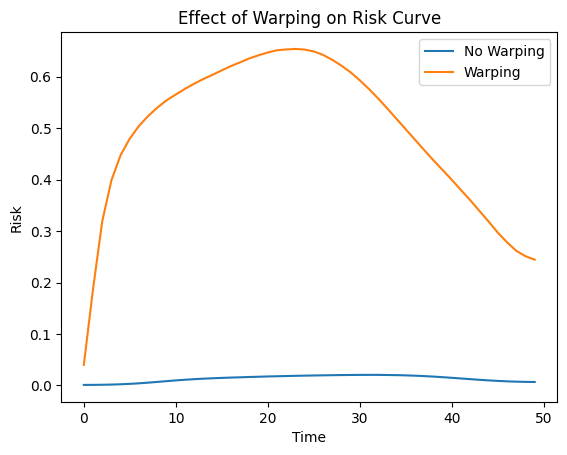

In [163]:
import matplotlib.pyplot as plt

plt.plot(pi_non_warp[0, 0, :].detach().cpu(), label='No Warping')
plt.plot(pi_warp[0, 0, :].detach().cpu(), label='Warping')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title('Effect of Warping on Risk Curve')
plt.show()

In [164]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Example dimensions
N = 2          # Number of individuals
K_total = 3     # Number of signatures
T = 10          # Number of time points

# Example warping parameters (rho)
rho = torch.tensor([[1.0, 2.0, 0.5],    # Individual 0: 3 signatures
                    [1.5, 1.0, 2.0]])  # Individual 1: 3 signatures
# Shape: [N, K_total]

print("rho shape:", rho.shape)
print("rho:\n", rho)


rho shape: torch.Size([2, 3])
rho:
 tensor([[1.0000, 2.0000, 0.5000],
        [1.5000, 1.0000, 2.0000]])


In [153]:

# Add a new axis for time
rho_exp = rho.unsqueeze(-1)  # Shape: [N, K_total, 1]
print("\nrho.unsqueeze(-1) shape:", rho_exp.shape)
print("rho.unsqueeze(-1):\n", rho_exp)



rho.unsqueeze(-1) shape: torch.Size([2, 3, 1])
rho.unsqueeze(-1):
 tensor([[[1.0000],
         [2.0000],
         [0.5000]],

        [[1.5000],
         [1.0000],
         [2.0000]]])


In [154]:

# Time grid
time_points = torch.arange(T, dtype=torch.float32)  # [0, 1, ..., T-1]
print("\ntime_points:", time_points)



time_points: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])


In [155]:

# Normalize time grid
T_minus_1 = T - 1
t_norm = time_points / T_minus_1  # Shape: [T]
print("\nt_norm:", t_norm)



t_norm: tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])


In [156]:

# Compute warped time
t_warped = (t_norm ** (1.0 / rho_exp)) * T_minus_1  # Shape: [N, K_total, T]
print("\nt_warped shape:", t_warped.shape)
print("t_warped[0, 0, :]:", t_warped[0, 0, :])  # Individual 0, signature 0
print("t_warped[1, 2, :]:", t_warped[1, 2, :])  # Individual 1, signature 2



t_warped shape: torch.Size([2, 3, 10])
t_warped[0, 0, :]: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
t_warped[1, 2, :]: tensor([0.0000, 3.0000, 4.2426, 5.1962, 6.0000, 6.7082, 7.3485, 7.9373, 8.4853,
        9.0000])


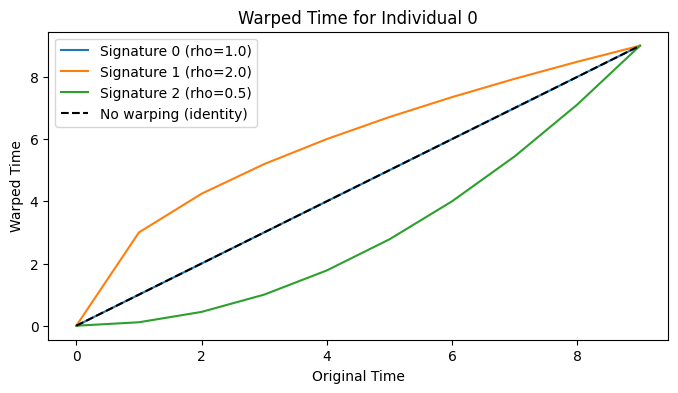

In [157]:

# Visualize for one individual and all signatures
plt.figure(figsize=(8, 4))
for k in range(K_total):
    plt.plot(t_norm.numpy() * T_minus_1, t_warped[0, k, :].numpy(), label=f'Signature {k} (rho={rho[0, k].item()})')
plt.plot(t_norm.numpy() * T_minus_1, t_norm.numpy() * T_minus_1, 'k--', label='No warping (identity)')
plt.xlabel('Original Time')
plt.ylabel('Warped Time')
plt.title('Warped Time for Individual 0')
plt.legend()
plt.show()

In [236]:

from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
np.random.seed(42)
torch.manual_seed(42)
model_no_warp = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True,
    disable_warping=True
)



/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 5 diseases
Cluster 1: 3 diseases
Cluster 2: 2 diseases
Cluster 3: 4 diseases
Cluster 4: 2 diseases
Cluster 5: 3 diseases
Cluster 6: 1 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 5
Base value (first 5): tensor([ -9.8460, -13.8155, -11.8308, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 2.4577, -1.5118,  0.4730, -1.5118, -1.5118])
Base value centered mean: -2.3704528757662047e-06
Gamma init for k=0 (first 5): tensor([ 0.5726,  0.4501, -0.3418,  0.0980, -0.0314])

Calculating gamma for k=1:
Number of diseases in cluster: 3
Base value (first 5): tensor([-10.5076, -10.5076, -13.8155,  -7.1997, -10.5076])
Base value centered (first 5): tensor([-1.4614, -1.4614, -4.7693,  1.8465, -1.4614])
Base value centered mean: -6.713867151120212e-08
Gamma init for k=1 (first 5): tensor([-0.9621,  0.1930, -0.4562,  0.6445, -0.2831])

Calculating gamma for k=2:
Number of diseases in cluster: 2
Base value (first 5): tensor([-3.8918, -3.8918, 

In [179]:
from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
K=5
# Store initial psi values
initial_psi = model.psi.detach().clone()

import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model_warp.fit(E_tensor, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:293: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 46.4964

Monitoring signature responses:

Disease 11 (signature 5, LR=25.15):
  Theta for diagnosed: 0.128 ± 0.048
  Theta for others: 0.094
  Proportion difference: 0.034

Disease 3 (signature 1, LR=23.45):
  Theta for diagnosed: 0.258 ± 0.190
  Theta for others: 0.160
  Proportion difference: 0.099

Disease 9 (signature 3, LR=23.19):
  Theta for diagnosed: 0.207 ± 0.098
  Theta for others: 0.144
  Proportion difference: 0.063

Disease 0 (signature 3, LR=22.44):
  Theta for diagnosed: 0.145 ± 0.093
  Theta for others: 0.097
  Proportion difference: 0.048

Disease 1 (signature 0, LR=21.60):
  Theta for diagnosed: 0.282 ± 0.164
  Theta for others: 0.145
  Proportion difference: 0.137

Epoch 1
Loss: 244.8178

Monitoring signature responses:

Disease 11 (signature 5, LR=25.32):
  Theta for diagnosed: 0.128 ± 0.047
  Theta for others: 0.094
  Proportion difference: 0.034

Disease 3 (signature 1, LR=23.47):
  Theta for diagnosed: 0.259 ± 0.190
  Theta for others: 0.160
  Prop

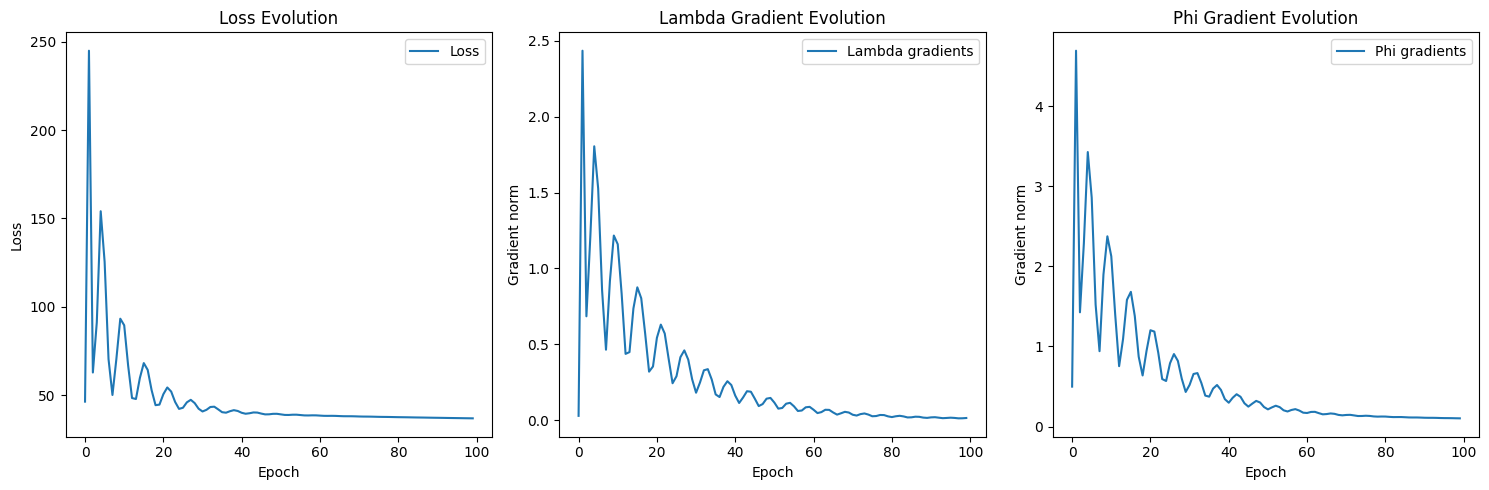

In [180]:
plot_training_evolution(history_new)

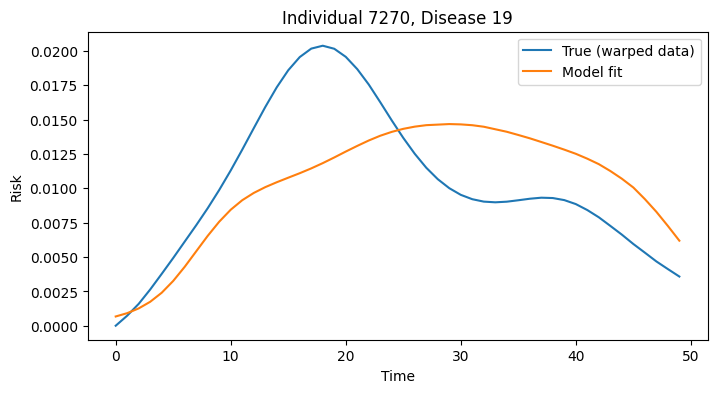

In [181]:
pi_pred=model_warp.forward()[0].detach().cpu()
pi_true = data_warp['pi']  # [N, D, T]


import matplotlib.pyplot as plt
import numpy as np

# Pick a random individual and disease
i = np.random.randint(pi_pred.shape[0])
d = np.random.randint(pi_pred.shape[1])

plt.figure(figsize=(8, 4))
plt.plot(pi_true[i, d, :], label='True (warped data)')
plt.plot(pi_pred[i, d, :], label='Model fit')
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title(f'Individual {i}, Disease {d}')
plt.legend()
plt.show()




# model with warp

In [282]:

from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
np.random.seed(42)
torch.manual_seed(42)
model_warp = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True,
    disable_warping=False
)




/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 5 diseases
Cluster 1: 3 diseases
Cluster 2: 2 diseases
Cluster 3: 4 diseases
Cluster 4: 2 diseases
Cluster 5: 3 diseases
Cluster 6: 1 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 5
Base value (first 5): tensor([ -9.8460, -13.8155, -11.8308, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 2.4577, -1.5118,  0.4730, -1.5118, -1.5118])
Base value centered mean: -2.3704528757662047e-06
Gamma init for k=0 (first 5): tensor([ 0.5726,  0.4501, -0.3418,  0.0980, -0.0314])

Calculating gamma for k=1:
Number of diseases in cluster: 3
Base value (first 5): tensor([-10.5076, -10.5076, -13.8155,  -7.1997, -10.5076])
Base value centered (first 5): tensor([-1.4614, -1.4614, -4.7693,  1.8465, -1.4614])
Base value centered mean: -6.713867151120212e-08
Gamma init for k=1 (first 5): tensor([-0.9621,  0.1930, -0.4562,  0.6445, -0.2831])

Calculating gamma for k=2:
Number of diseases in cluster: 2
Base value (first 5): tensor([-3.8918, -3.8918, 

In [284]:
from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
K=7
# Store initial psi values


import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model_warp.fit(E_tensor, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

rho stats: min = 0.9923642873764038 max = 1.0108346939086914 mean = 1.0010030269622803
t_warped stats: min = 0.0 max = 49.0 mean = 24.511993408203125
t_warped[0, 0, :10]: [0.        1.0100521 2.0165088 3.021613  4.0258393 5.0294147 6.03247
 7.0350947 8.037349  9.039281 ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.0880, grad_fn=<MaxBackward1>)
phi_prob_warped stats: min = 2.612882799013505e-09 max = 0.08802050352096558
phi min/max: -19.7628116607666 -2.338047742843628
phi_prob_warped min/max: 2.612882799013505e-09 0.08802050352096558
theta min/max: 0.0005077330279164016 0.9641402363777161
pi (before clamp) min/max: 3.389655889307619e-09 0.08908890187740326
theta shape: torch.Size([10000, 7, 50])
phi_prob_warped shape: torch.Size([7, 20, 10000, 50])
kappa: Parameter containing:
tensor([1.1000], requires_grad=True)


/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:320: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_no_event = -torch.sum(torch.log(1 - pi) * mask_at_event * (1 - self.Y))


rho grad norm: 0.0727771446108818

Epoch 0
Loss: 265.7902
rho stats: min = 0.984786868095398 max = 1.0217868089675903 mean = 1.002012014389038
t_warped stats: min = 0.0 max = 49.0 mean = 24.523988723754883
t_warped[0, 0, :10]: [0.        1.0201792 2.033111  3.0433257 4.0517797 5.0589266 6.0650325
 7.0702744 8.074777  9.078633 ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.0888)
phi_prob_warped stats: min = 2.586883596222833e-09 max = 0.08882654458284378
phi min/max: -19.772811889648438 -2.328047752380371
phi_prob_warped min/max: 2.586883596222833e-09 0.08882654458284378
theta min/max: 0.0004988316795788705 0.9594263434410095
pi (before clamp) min/max: 3.7115615025840043e-09 0.09729363024234772
theta shape: torch.Size([10000, 7, 50])
phi_prob_warped shape: torch.Size([7, 20, 10000, 50])
kappa: Parameter containing:
tensor([1.2000], requires_grad=True)

Monitoring signature responses:

Disease 11 (signature 5, LR=24.98):
  Theta for diagnosed: 0.128 ± 0.046
  Theta for othe

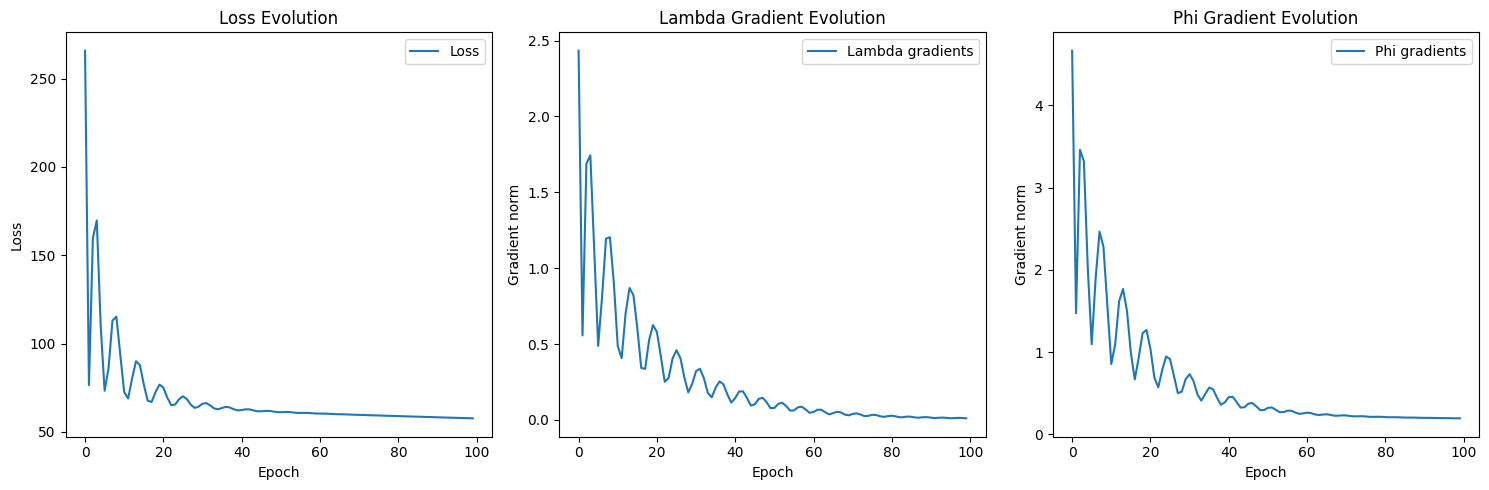

In [285]:
plot_training_evolution(history_new)

rho stats: min = 0.42824551463127136 max = 3.1770005226135254 mean = 1.1272166967391968
t_warped stats: min = 0.0 max = 49.0 mean = 25.59355354309082
t_warped[0, 0, :10]: [ 0.         2.3409324  4.023735   5.5237784  6.9162374  8.233803
  9.494602  10.710074  11.888043  13.034179 ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.0458, grad_fn=<MaxBackward1>)
phi_prob_warped stats: min = 2.5996895747226745e-09 max = 0.04577014967799187
phi min/max: -19.767873764038086 -3.0372719764709473
phi_prob_warped min/max: 2.5996895747226745e-09 0.04577014967799187
theta min/max: 0.0006191423162817955 0.9613170027732849
pi (before clamp) min/max: 1.1307491831757943e-08 0.16186578571796417
theta shape: torch.Size([10000, 7, 50])
phi_prob_warped shape: torch.Size([7, 20, 10000, 50])
kappa: Parameter containing:
tensor([3.6875], requires_grad=True)


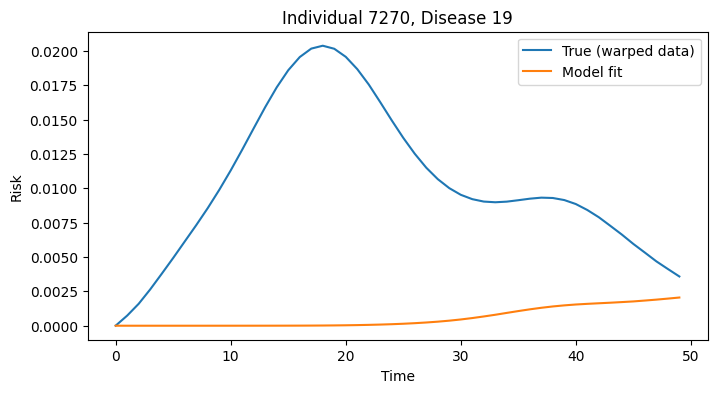

In [286]:
pi_pred=model_warp.forward()[0].detach().cpu()
pi_true = data_warp['pi']  # [N, D, T]


import matplotlib.pyplot as plt
import numpy as np

# Pick a random individual and disease
i = np.random.randint(pi_pred.shape[0])
d = np.random.randint(pi_pred.shape[1])

plt.figure(figsize=(8, 4))
plt.plot(pi_true[i, d, :], label='True (warped data)')
plt.plot(pi_pred[i, d, :], label='Model fit')
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title(f'Individual {i}, Disease {d}')
plt.legend()
plt.show()

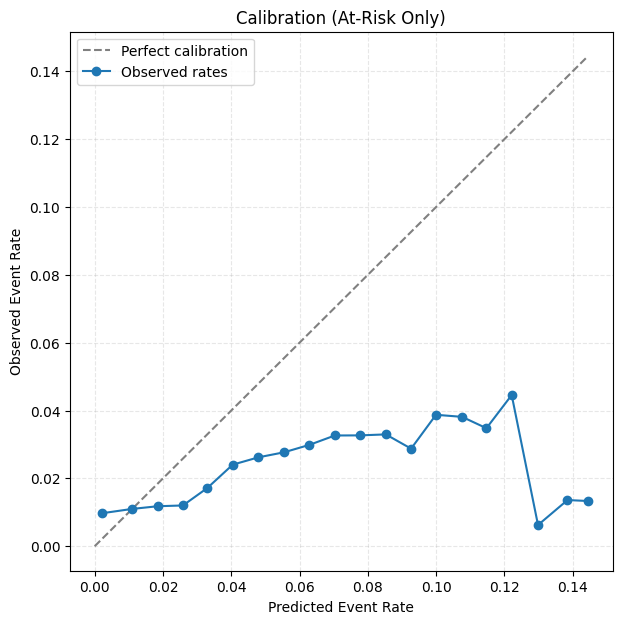

MSE: 4.12e-03
Mean Predicted: 1.07e-02
Mean Observed: 1.13e-02
N total: 7,734,127


([np.float32(0.0021063383),
  np.float32(0.010875535),
  np.float32(0.01842862),
  np.float32(0.025842533),
  np.float32(0.0329733),
  np.float32(0.040420778),
  np.float32(0.04793445),
  np.float32(0.05546322),
  np.float32(0.06289315),
  np.float32(0.07033281),
  np.float32(0.07772798),
  np.float32(0.085261),
  np.float32(0.09266026),
  np.float32(0.099950835),
  np.float32(0.10760061),
  np.float32(0.114716604),
  np.float32(0.12211984),
  np.float32(0.12982838),
  np.float32(0.13846117),
  np.float32(0.14442664)],
 [np.float32(0.009716073),
  np.float32(0.01098222),
  np.float32(0.0117843505),
  np.float32(0.012014512),
  np.float32(0.017147508),
  np.float32(0.02404011),
  np.float32(0.026200078),
  np.float32(0.027686242),
  np.float32(0.029877517),
  np.float32(0.032639544),
  np.float32(0.032669984),
  np.float32(0.032960735),
  np.float32(0.028756958),
  np.float32(0.03874092),
  np.float32(0.03812825),
  np.float32(0.034782607),
  np.float32(0.044554457),
  np.float32(0.0062

In [287]:
import numpy as np
import matplotlib.pyplot as plt

def plot_calibration_at_risk(pi, Y, n_bins=20, min_bin_count=50, use_log_scale=False):
    """
    Plots calibration curve for at-risk only time points.
    Args:
        pi: [N, D, T] predicted probabilities (torch.Tensor or np.ndarray)
        Y: [N, D, T] observed events (torch.Tensor or np.ndarray)
        n_bins: number of bins for calibration
        min_bin_count: minimum number of samples per bin
        use_log_scale: whether to use log scale for bins/axes
    """
    if hasattr(pi, 'detach'):
        pi = pi.detach().cpu().numpy()
    if hasattr(Y, 'detach'):
        Y = Y.detach().cpu().numpy()
    N, D, T = Y.shape

    # Create at-risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n, d, :])[0]
            if len(event_times) > 0:
                at_risk[n, d, (event_times[0]+1):] = False

    # Gather predictions and observations for at-risk only
    pred = pi[at_risk]
    obs = Y[at_risk]

    # Bin predictions
    if use_log_scale:
        bin_edges = np.logspace(np.log10(max(1e-7, pred.min())), np.log10(pred.max()), n_bins + 1)
    else:
        bin_edges = np.linspace(pred.min(), pred.max(), n_bins + 1)

    bin_means = []
    obs_means = []
    counts = []

    for i in range(n_bins):
        mask = (pred >= bin_edges[i]) & (pred < bin_edges[i + 1])
        if np.sum(mask) >= min_bin_count:
            bin_means.append(np.mean(pred[mask]))
            obs_means.append(np.mean(obs[mask]))
            counts.append(np.sum(mask))

    # Plot
    plt.figure(figsize=(7, 7))
    if use_log_scale:
        plt.xscale('log')
        plt.yscale('log')
        plt.plot([1e-7, 1], [1e-7, 1], '--', color='gray', label='Perfect calibration')
    else:
        plt.plot([0, max(bin_means + obs_means)], [0, max(bin_means + obs_means)], '--', color='gray', label='Perfect calibration')

    plt.plot(bin_means, obs_means, 'o-', label='Observed rates')
    plt.xlabel('Predicted Event Rate')
    plt.ylabel('Observed Event Rate')
    plt.title('Calibration (At-Risk Only)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.show()

    # Print summary stats
    mse = np.mean((np.array(bin_means) - np.array(obs_means))**2)
    print(f'MSE: {mse:.2e}')
    print(f'Mean Predicted: {np.mean(pred):.2e}')
    print(f'Mean Observed: {np.mean(obs):.2e}')
    print(f'N total: {len(pred):,}')

    return bin_means, obs_means, counts

plot_calibration_at_risk(pi_pred, Y_tensor, n_bins=20, min_bin_count=50, use_log_scale=False)

In [288]:
pi_pred_nw=model_no_warp.forward()[0].detach().cpu()

pi (before clamp) min/max: 9.03231178739361e-09 0.22823397815227509


In [289]:
pi_pred_w=model_warp.forward()[0].detach().cpu()

rho stats: min = 0.42824551463127136 max = 3.1770005226135254 mean = 1.1272166967391968
t_warped stats: min = 0.0 max = 49.0 mean = 25.59355354309082
t_warped[0, 0, :10]: [ 0.         2.3409324  4.023735   5.5237784  6.9162374  8.233803
  9.494602  10.710074  11.888043  13.034179 ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.0458, grad_fn=<MaxBackward1>)
phi_prob_warped stats: min = 2.5996895747226745e-09 max = 0.04577014967799187
phi min/max: -19.767873764038086 -3.0372719764709473
phi_prob_warped min/max: 2.5996895747226745e-09 0.04577014967799187
theta min/max: 0.0006191423162817955 0.9613170027732849
pi (before clamp) min/max: 1.1307491831757943e-08 0.16186578571796417
theta shape: torch.Size([10000, 7, 50])
phi_prob_warped shape: torch.Size([7, 20, 10000, 50])
kappa: Parameter containing:
tensor([3.6875], requires_grad=True)


pi (before clamp) min/max: 9.03231178739361e-09 0.22823397815227509


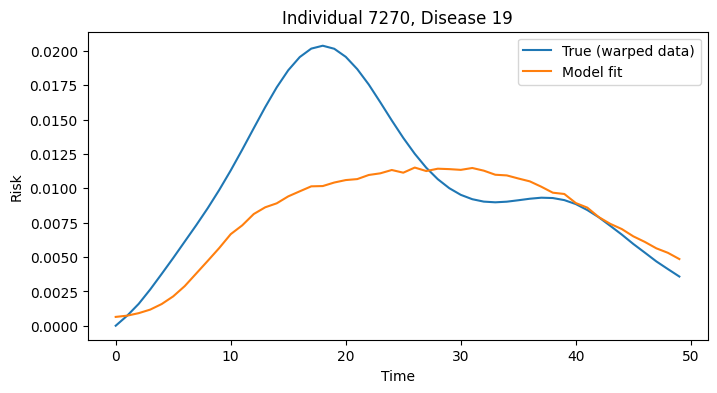

In [270]:
pi_pred=model_no_warp.forward()[0].detach().cpu()
pi_true = data_warp['pi']  # [N, D, T]


import matplotlib.pyplot as plt
import numpy as np

# Pick a random individual and disease
i = np.random.randint(pi_pred.shape[0])
d = np.random.randint(pi_pred.shape[1])

plt.figure(figsize=(8, 4))
plt.plot(pi_true[i, d, :], label='True (warped data)')
plt.plot(pi_pred[i, d, :], label='Model fit')
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title(f'Individual {i}, Disease {d}')
plt.legend()
plt.show()

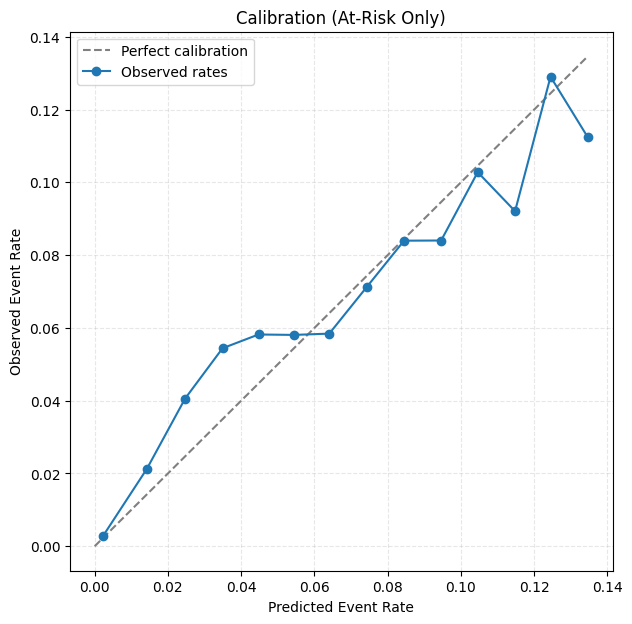

MSE: 1.48e-04
Mean Predicted: 8.33e-03
Mean Observed: 1.13e-02
N total: 7,734,127


([np.float32(0.0022114124),
  np.float32(0.014234133),
  np.float32(0.024697214),
  np.float32(0.034906354),
  np.float32(0.044736627),
  np.float32(0.05437784),
  np.float32(0.06405774),
  np.float32(0.07423889),
  np.float32(0.08447085),
  np.float32(0.09460102),
  np.float32(0.10458307),
  np.float32(0.114784345),
  np.float32(0.12447042),
  np.float32(0.13466275)],
 [np.float32(0.0027100833),
  np.float32(0.02123962),
  np.float32(0.040590707),
  np.float32(0.054401986),
  np.float32(0.058188893),
  np.float32(0.058072887),
  np.float32(0.058428273),
  np.float32(0.07117833),
  np.float32(0.08396785),
  np.float32(0.08401827),
  np.float32(0.10279531),
  np.float32(0.09208103),
  np.float32(0.12903225),
  np.float32(0.11235955)],
 [np.int64(5880631),
  np.int64(777980),
  np.int64(380900),
  np.int64(290596),
  np.int64(223565),
  np.int64(120211),
  np.int64(39587),
  np.int64(11703),
  np.int64(4728),
  np.int64(2190),
  np.int64(1109),
  np.int64(543),
  np.int64(248),
  np.int6

In [272]:
plot_calibration_at_risk(pi_pred, Y_tensor, n_bins=20, min_bin_count=50, use_log_scale=False)


STaged training

In [298]:

from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
np.random.seed(42)
torch.manual_seed(42)
model_staged = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True,
    disable_warping=True
)




import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model_staged.fit(E_tensor, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)
from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
K=5
# Store initial psi values




/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 5 diseases
Cluster 1: 3 diseases
Cluster 2: 2 diseases
Cluster 3: 4 diseases
Cluster 4: 2 diseases
Cluster 5: 3 diseases
Cluster 6: 1 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 5
Base value (first 5): tensor([ -9.8460, -13.8155, -11.8308, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 2.4577, -1.5118,  0.4730, -1.5118, -1.5118])
Base value centered mean: -2.3704528757662047e-06
Gamma init for k=0 (first 5): tensor([ 0.5726,  0.4501, -0.3418,  0.0980, -0.0314])

Calculating gamma for k=1:
Number of diseases in cluster: 3
Base value (first 5): tensor([-10.5076, -10.5076, -13.8155,  -7.1997, -10.5076])
Base value centered (first 5): tensor([-1.4614, -1.4614, -4.7693,  1.8465, -1.4614])
Base value centered mean: -6.713867151120212e-08
Gamma init for k=1 (first 5): tensor([-0.9621,  0.1930, -0.4562,  0.6445, -0.2831])

Calculating gamma for k=2:
Number of diseases in cluster: 2
Base value (first 5): tensor([-3.8918, -3.8918, 

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:320: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 46.4964
pi (before clamp) min/max: 3.3734581794675478e-09 0.06806183606386185

Monitoring signature responses:

Disease 11 (signature 5, LR=25.15):
  Theta for diagnosed: 0.128 ± 0.048
  Theta for others: 0.094
  Proportion difference: 0.034

Disease 3 (signature 1, LR=23.45):
  Theta for diagnosed: 0.258 ± 0.190
  Theta for others: 0.160
  Proportion difference: 0.099

Disease 9 (signature 3, LR=23.19):
  Theta for diagnosed: 0.207 ± 0.098
  Theta for others: 0.144
  Proportion difference: 0.063

Disease 0 (signature 3, LR=22.44):
  Theta for diagnosed: 0.145 ± 0.093
  Theta for others: 0.097
  Proportion difference: 0.048

Disease 1 (signature 0, LR=21.60):
  Theta for diagnosed: 0.282 ± 0.164
  Theta for others: 0.145
  Proportion difference: 0.137
pi (before clamp) min/max: 3.3734581794675478e-09 0.06806183606386185

Epoch 1
Loss: 244.8178
pi (before clamp) min/max: 3.636245748950273e-09 0.07457747310400009

Monitoring signature responses:

Disease 11 (signature 5, L

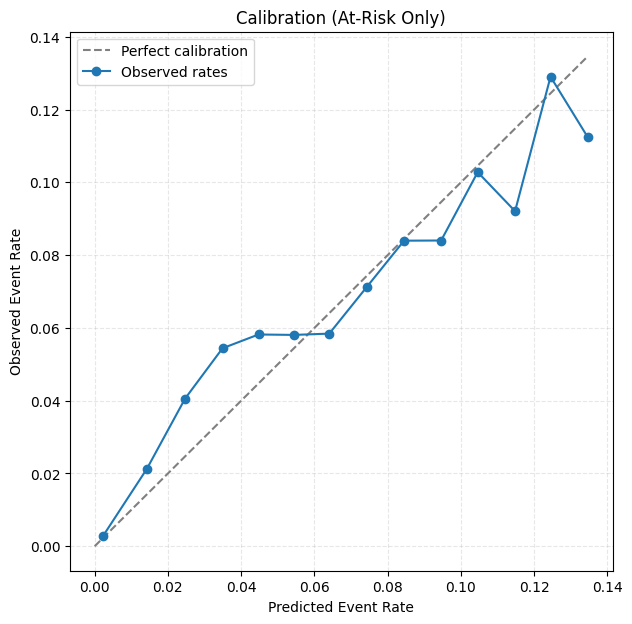

MSE: 1.48e-04
Mean Predicted: 8.33e-03
Mean Observed: 1.13e-02
N total: 7,734,127


([np.float32(0.0022114124),
  np.float32(0.014234133),
  np.float32(0.024697214),
  np.float32(0.034906354),
  np.float32(0.044736627),
  np.float32(0.05437784),
  np.float32(0.06405774),
  np.float32(0.07423889),
  np.float32(0.08447085),
  np.float32(0.09460102),
  np.float32(0.10458307),
  np.float32(0.114784345),
  np.float32(0.12447042),
  np.float32(0.13466275)],
 [np.float32(0.0027100833),
  np.float32(0.02123962),
  np.float32(0.040590707),
  np.float32(0.054401986),
  np.float32(0.058188893),
  np.float32(0.058072887),
  np.float32(0.058428273),
  np.float32(0.07117833),
  np.float32(0.08396785),
  np.float32(0.08401827),
  np.float32(0.10279531),
  np.float32(0.09208103),
  np.float32(0.12903225),
  np.float32(0.11235955)],
 [np.int64(5880631),
  np.int64(777980),
  np.int64(380900),
  np.int64(290596),
  np.int64(223565),
  np.int64(120211),
  np.int64(39587),
  np.int64(11703),
  np.int64(4728),
  np.int64(2190),
  np.int64(1109),
  np.int64(543),
  np.int64(248),
  np.int6

In [ ]:
plot_calibration_at_risk(pi_pred, Y_tensor, n_bins=20, min_bin_count=50, use_log_scale=False)


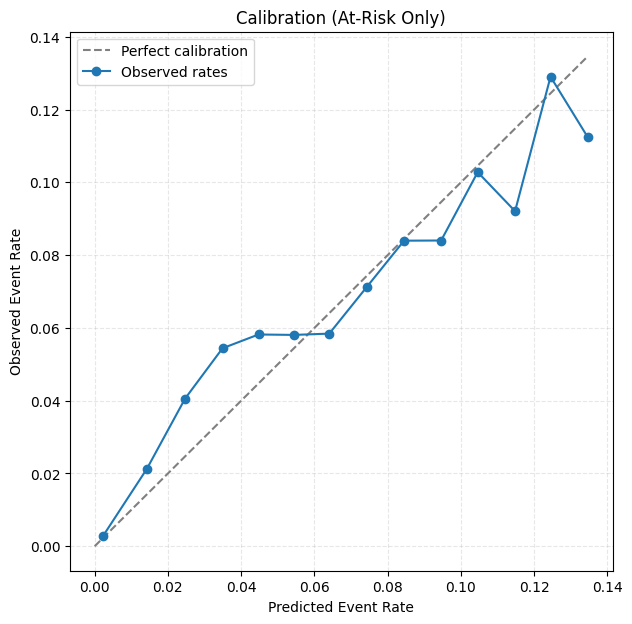

MSE: 1.48e-04
Mean Predicted: 8.33e-03
Mean Observed: 1.13e-02
N total: 7,734,127


([np.float32(0.0022114124),
  np.float32(0.014234133),
  np.float32(0.024697214),
  np.float32(0.034906354),
  np.float32(0.044736627),
  np.float32(0.05437784),
  np.float32(0.06405774),
  np.float32(0.07423889),
  np.float32(0.08447085),
  np.float32(0.09460102),
  np.float32(0.10458307),
  np.float32(0.114784345),
  np.float32(0.12447042),
  np.float32(0.13466275)],
 [np.float32(0.0027100833),
  np.float32(0.02123962),
  np.float32(0.040590707),
  np.float32(0.054401986),
  np.float32(0.058188893),
  np.float32(0.058072887),
  np.float32(0.058428273),
  np.float32(0.07117833),
  np.float32(0.08396785),
  np.float32(0.08401827),
  np.float32(0.10279531),
  np.float32(0.09208103),
  np.float32(0.12903225),
  np.float32(0.11235955)],
 [np.int64(5880631),
  np.int64(777980),
  np.int64(380900),
  np.int64(290596),
  np.int64(223565),
  np.int64(120211),
  np.int64(39587),
  np.int64(11703),
  np.int64(4728),
  np.int64(2190),
  np.int64(1109),
  np.int64(543),
  np.int64(248),
  np.int6

In [ ]:
plot_calibration_at_risk(pi_pred, Y_tensor, n_bins=20, min_bin_count=50, use_log_scale=False)


pi (before clamp) min/max: 1.2180164432606944e-08 0.5939434170722961


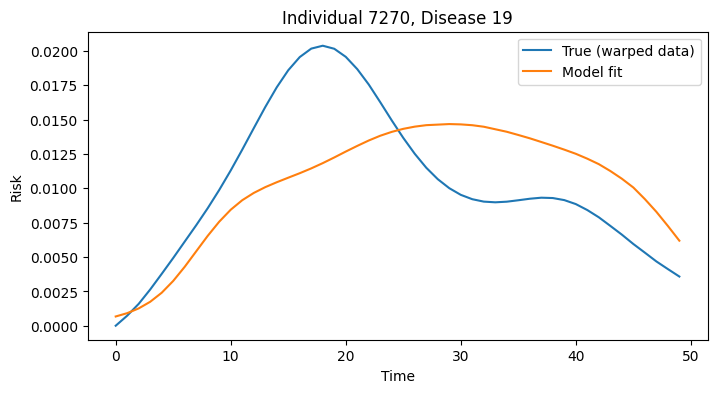

In [294]:
pi_pred=model_staged.forward()[0].detach().cpu()
pi_true = data_warp['pi']  # [N, D, T]


import matplotlib.pyplot as plt
import numpy as np

# Pick a random individual and disease
i = np.random.randint(pi_pred.shape[0])
d = np.random.randint(pi_pred.shape[1])

plt.figure(figsize=(8, 4))
plt.plot(pi_true[i, d, :], label='True (warped data)')
plt.plot(pi_pred[i, d, :], label='Model fit')
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title(f'Individual {i}, Disease {d}')
plt.legend()
plt.show()

In [ ]:
plot_calibration_at_risk(pi_pred, Y_tensor, n_bins=20, min_bin_count=50, use_log_scale=False)


# now run and fit the warping 

In [295]:


model_staged.lambda_.requires_grad = False
model_staged.phi.requires_grad = False
model_staged.disable_warping = False
profiler = cProfile.Profile()
profiler.enable()
history_new = model_staged.fit(E_tensor, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

rho stats: min = 1.0 max = 1.0 mean = 1.0
t_warped stats: min = 0.0 max = 49.0 mean = 24.499996185302734
t_warped[0, 0, :10]: [0.        1.        2.        3.        4.        5.        6.
 7.0000005 8.        9.       ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.1519, grad_fn=<MaxBackward1>)
phi_prob_warped stats: min = 2.589312320111503e-09 max = 0.15186065435409546
phi min/max: -19.771873474121094 -1.7200815677642822
phi_prob_warped min/max: 2.589312320111503e-09 0.15186065435409546
theta min/max: 0.0005652636173181236 0.95958012342453
pi (before clamp) min/max: 1.1617225403881548e-08 0.5602264404296875
theta shape: torch.Size([10000, 7, 50])
phi_prob_warped shape: torch.Size([7, 20, 10000, 50])
kappa: Parameter containing:
tensor([4.0909], requires_grad=True)
rho grad norm: 0.07399776577949524

Epoch 0
Loss: 66.1726
rho stats: min = 0.9920104146003723 max = 1.0097707509994507 mean = 1.0010030269622803
t_warped stats: min = 0.0 max = 49.0 mean = 24.511993408203125
t

rho stats: min = 0.43883395195007324 max = 2.879443645477295 mean = 1.1332899332046509
t_warped stats: min = 0.0 max = 49.0 mean = 25.692533493041992
t_warped[0, 0, :10]: [ 0.         2.4415565  4.1653543  5.693175   7.1061945  8.439556
  9.712694  10.937837  12.123339  13.275238 ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.1519, grad_fn=<MaxBackward1>)
phi_prob_warped stats: min = 2.589312320111503e-09 max = 0.15186065435409546
phi min/max: -19.771873474121094 -1.7200815677642822
phi_prob_warped min/max: 2.589312320111503e-09 0.15186065435409546
theta min/max: 0.0005652636173181236 0.95958012342453
pi (before clamp) min/max: 6.8271091002714e-09 0.32760757207870483
theta shape: torch.Size([10000, 7, 50])
phi_prob_warped shape: torch.Size([7, 20, 10000, 50])
kappa: Parameter containing:
tensor([2.4041], requires_grad=True)


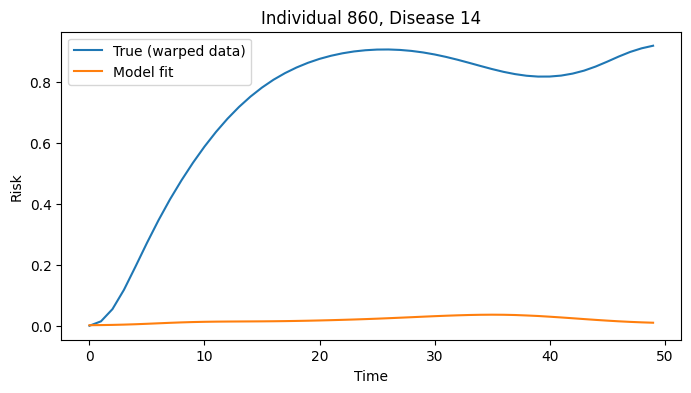

In [296]:
pi_pred=model_staged.forward()[0].detach().cpu()
pi_true = data_warp['pi']  # [N, D, T]


import matplotlib.pyplot as plt
import numpy as np

# Pick a random individual and disease
i = np.random.randint(pi_pred.shape[0])
d = np.random.randint(pi_pred.shape[1])

plt.figure(figsize=(8, 4))
plt.plot(pi_true[i, d, :], label='True (warped data)')
plt.plot(pi_pred[i, d, :], label='Model fit')
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title(f'Individual {i}, Disease {d}')
plt.legend()
plt.show()

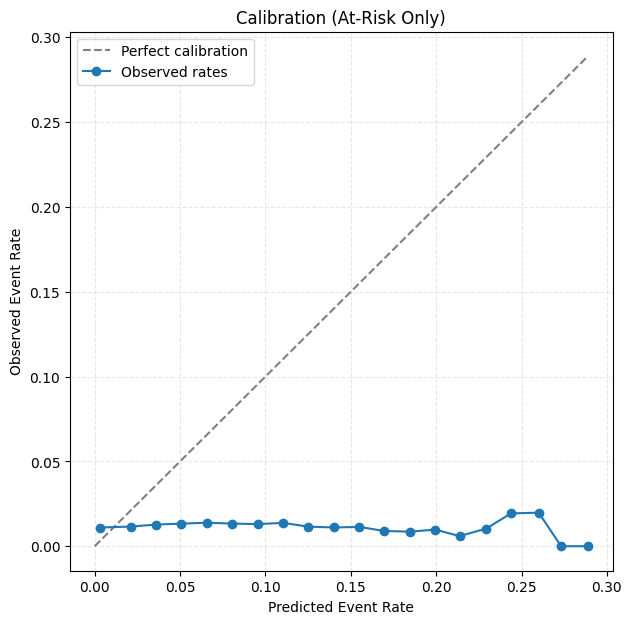

MSE: 2.63e-02
Mean Predicted: 1.10e-02
Mean Observed: 1.13e-02
N total: 7,734,127


([np.float32(0.0032114526),
  np.float32(0.021533156),
  np.float32(0.036103297),
  np.float32(0.050746102),
  np.float32(0.065633655),
  np.float32(0.08063399),
  np.float32(0.09562316),
  np.float32(0.11038271),
  np.float32(0.12521704),
  np.float32(0.1402644),
  np.float32(0.15502973),
  np.float32(0.16952677),
  np.float32(0.18467216),
  np.float32(0.1994786),
  np.float32(0.2136829),
  np.float32(0.2293507),
  np.float32(0.24377708),
  np.float32(0.26003283),
  np.float32(0.2731916),
  np.float32(0.2888464)],
 [np.float32(0.011024067),
  np.float32(0.011608718),
  np.float32(0.012772237),
  np.float32(0.013321615),
  np.float32(0.013848868),
  np.float32(0.013345132),
  np.float32(0.0130464025),
  np.float32(0.013746248),
  np.float32(0.011536297),
  np.float32(0.011049724),
  np.float32(0.011387164),
  np.float32(0.009),
  np.float32(0.008571428),
  np.float32(0.009803922),
  np.float32(0.005964215),
  np.float32(0.010416667),
  np.float32(0.019323671),
  np.float32(0.01980198),

In [297]:
plot_calibration_at_risk(pi_pred, Y_tensor, n_bins=20, min_bin_count=50, use_log_scale=False)
